In [1]:
import pandas as pd

import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sn

import random
import os

In [2]:
sequence_path = "chr_seq/"
annotation_path = "combined_annotations.csv"

In [3]:
annotations = pd.read_csv(annotation_path, sep='\t')

In [4]:
annotations = annotations[~annotations['label'].isin(['CTCF', 'K4m3', 'prom'])]

In [5]:
annotations['label'] = np.where(
    annotations['label'] == 'junk', 
    'other', 
    annotations['label']
)

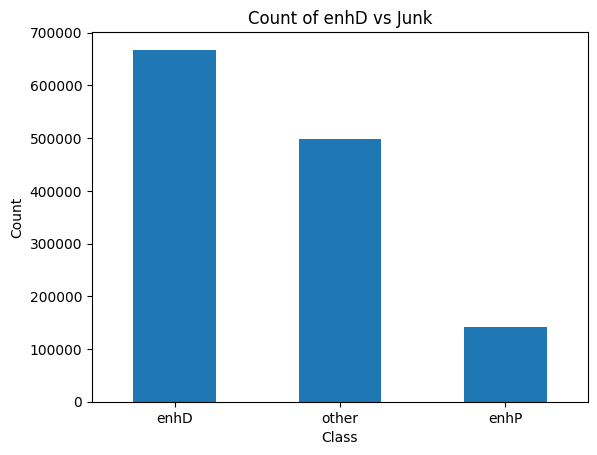

In [6]:


class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhD vs Junk')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [7]:
class_counts

label
enhD     667599
other    497738
enhP     141830
Name: count, dtype: int64

In [8]:
num_enhP = len(annotations[annotations['label'] == 'enhP'])
num_enhP

141830

In [9]:
ann_temp = annotations[annotations['label'] == 'enhP'].copy()

for label in ['enhD','other']:

# for label in ['enhD', 'other']:
    
    annotations_sampled = annotations[annotations['label'] == label].sample(n=num_enhP, random_state=42)

    ann_temp = pd.concat([ann_temp, annotations_sampled])

# Now you can proceed to create your dataset with 'balanced_annotations'
# instead of the full 'annotations' DataFrame

In [10]:
annotations = ann_temp

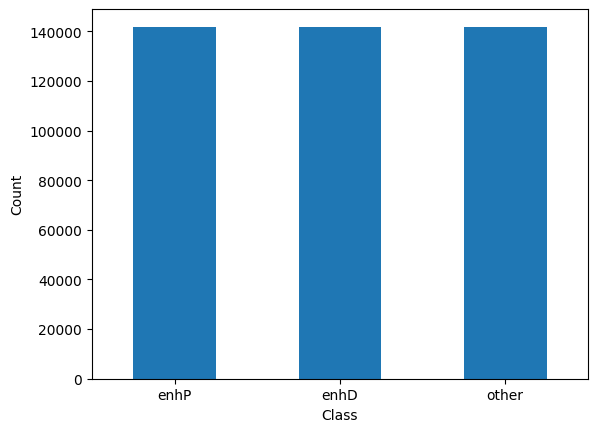

In [11]:
class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [12]:
annotations.head()

,chrom,frameStart,frameEnd,label
0,chr1,181248,181648,enhP
6,chr1,779668,780068,enhP
16,chr1,817864,818264,enhP
18,chr1,818675,819075,enhP
22,chr1,826708,827108,enhP


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DNADataset(Dataset):
    def __init__(self, sequence, annotations, encoding_type='integer'):
        self.sequence = sequence
        self.annotations = annotations
        self.encoding_type = encoding_type
        self.sections = self._extract_sections()
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):     
        start, end, label = self.sections[index]
        sequence_section = self.sequence[start:end]
        sequence_section = [self._map_dna_letter(letter) for letter in sequence_section]
        sequence_section = torch.tensor(sequence_section).T
        
        return sequence_section, label
    
    def _extract_sections(self):
        sections = []
        # Iterate over each annotation
        for _, row in self.annotations.iterrows():
            start = row['frameStart']
            end = row['frameEnd']
            label = self._map_annotation_type(row['label'])
            sections.append((start, end, label))
        return sections

    def _map_dna_letter(self, letter):
        if self.encoding_type == 'integer':
            if letter == 'A':
                return 1
            elif letter == 'C':
                return 2
            elif letter == 'G':
                return 3
            elif letter == 'T':
                return 4
            elif letter == 'N':
                return 5
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        elif self.encoding_type == 'one_hot':
            if letter == 'A':
                return [1, 0, 0, 0]
            elif letter == 'C':
                return [0, 1, 0, 0]
            elif letter == 'G':
                return [0, 0, 1, 0]
            elif letter == 'T':
                return [0, 0, 0, 1]
            elif letter == 'N':
                return [0, 0, 0, 0]
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        else:
            raise ValueError(f"Invalid encoding type: {self.encoding_type}")
    
    @staticmethod
    def _map_annotation_type(annotation_type):
        if annotation_type == 'enhP':
            return 1
        elif annotation_type == 'enhD':
            return 2
        elif annotation_type == 'other':
            return 0

In [15]:
# Create a list of chromosome names including chrX and chrY
chr_sequences = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

dataset = []

for seq in chr_sequences:
    # Read DNA sequence file
    print(f'Processing {seq}...')
    sequence_file_path = f'{sequence_path}/{seq}.fa'
    annotations_for_seq = annotations[annotations['chrom'] == seq]
    print(f'Number of annotations for {seq}: {annotations_for_seq.shape[0]}')
    
    with open(sequence_file_path, 'r') as file:
        # Skip the first line which is the header
        next(file)
        # Read the sequence, remove newlines and convert to uppercase
        dna_sequence = file.read().replace("\n", "").upper()
        
        # Initialize the dataset for this chromosome with its annotations
        ds = DNADataset(dna_sequence, annotations_for_seq, encoding_type='one_hot')
        # Extend the main dataset with the data from this chromosome
        dataset.extend(ds)

# Split into training and testing sets (adjust ratios as per your needs)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])



Processing chr1...
Number of annotations for chr1: 38827
Processing chr2...
Number of annotations for chr2: 34336
Processing chr3...
Number of annotations for chr3: 28037
Processing chr4...
Number of annotations for chr4: 20853
Processing chr5...
Number of annotations for chr5: 23641
Processing chr6...
Number of annotations for chr6: 25049
Processing chr7...
Number of annotations for chr7: 21897
Processing chr8...
Number of annotations for chr8: 19832
Processing chr9...
Number of annotations for chr9: 17666
Processing chr10...
Number of annotations for chr10: 19994
Processing chr11...
Number of annotations for chr11: 21631
Processing chr12...
Number of annotations for chr12: 21612
Processing chr13...
Number of annotations for chr13: 11258
Processing chr14...
Number of annotations for chr14: 14241
Processing chr15...
Number of annotations for chr15: 13880
Processing chr16...
Number of annotations for chr16: 14316
Processing chr17...
Number of annotations for chr17: 18581
Processing chr1

In [16]:
train_dataset.__len__()

382941

In [17]:
print(train_dataset.__getitem__(1))

(tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0]]), 2)


In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 50, 128)  # Assuming max pooling is applied 3 times
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        x = nn.functional.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x


In [19]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the training parameters
batch_size = 64
num_epochs = 30
learning_rate = 0.001

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [21]:

# Create an instance of the CNN model
model = CNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    total_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        # Convert data types
        inputs = inputs.float()
        labels = labels.long()
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_dataset)
    accuracy = correct_predictions / len(train_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/30], Loss: 0.9548, Accuracy: 0.5305
Epoch [2/30], Loss: 0.9141, Accuracy: 0.5634
Epoch [3/30], Loss: 0.9003, Accuracy: 0.5723
Epoch [4/30], Loss: 0.8920, Accuracy: 0.5776
Epoch [5/30], Loss: 0.8869, Accuracy: 0.5818
Epoch [6/30], Loss: 0.8834, Accuracy: 0.5836
Epoch [7/30], Loss: 0.8800, Accuracy: 0.5864
Epoch [8/30], Loss: 0.8776, Accuracy: 0.5868
Epoch [9/30], Loss: 0.8750, Accuracy: 0.5896
Epoch [10/30], Loss: 0.8724, Accuracy: 0.5907
Epoch [11/30], Loss: 0.8710, Accuracy: 0.5919
Epoch [12/30], Loss: 0.8689, Accuracy: 0.5932
Epoch [13/30], Loss: 0.8677, Accuracy: 0.5938
Epoch [14/30], Loss: 0.8658, Accuracy: 0.5952
Epoch [15/30], Loss: 0.8643, Accuracy: 0.5959
Epoch [16/30], Loss: 0.8633, Accuracy: 0.5969
Epoch [17/30], Loss: 0.8619, Accuracy: 0.5979
Epoch [18/30], Loss: 0.8601, Accuracy: 0.5984
Epoch [19/30], Loss: 0.8594, Accuracy: 0.5996
Epoch [20/30], Loss: 0.8587, Accuracy: 0.6004
Epoch [21/30], Loss: 0.8576, Accuracy: 0.5993
Epoch [22/30], Loss: 0.8560, Accuracy: 0.60

In [22]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
predicted_labels = []
true_labels = []

for inputs, labels in test_loader:
    # Convert data types
    inputs = inputs.float()
    labels = labels.long()
    inputs, labels = inputs.to(device), labels.to(device)

    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct_predictions += (predicted == labels).sum().item()
    
    # true_labels.append(labels.numpy().flatten())
    # predicted_labels.append(predicted.numpy().flatten())
    true_labels.append(labels.cpu().numpy().flatten())  # Move labels to CPU and convert to NumPy
    predicted_labels.append(predicted.cpu().numpy().flatten())  # Move predicted labels to CPU and convert to NumPy

avg_loss = total_loss / len(test_dataset)
accuracy = correct_predictions / len(test_dataset)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 0.8909, Test Accuracy: 0.5771


In [23]:
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

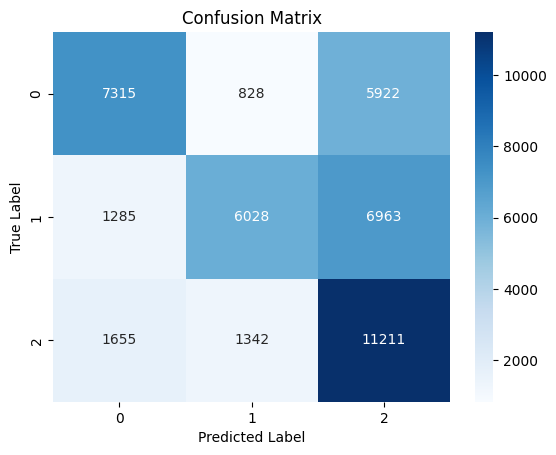

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.52      0.60     14065
           1       0.74      0.42      0.54     14276
           2       0.47      0.79      0.59     14208

    accuracy                           0.58     42549
   macro avg       0.64      0.58      0.57     42549
weighted avg       0.64      0.58      0.57     42549



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names
# Create a confusion matrix plot
fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)



# Add labels, title, and ticks
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')



# Show the plot
plt.show()

report = classification_report(true_labels, predicted_labels)

# Print the confusion matrix and classification report
# print('Confusion Matrix:')
# print(confusion_mat)
print('Classification Report:')
print(report)

